# General Imports

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import time

from functools import singledispatch
import warnings
import logging

# dataset
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import StandardScaler

# pyspark module
from pyspark.rdd import RDD # type: ignore

# src module
from utils import kddSetup, local_sparkSetup
from kmeans import compute_centroidDistances, get_clusterId, get_minDistance, cost_function, kMeansParallel_init, kMeansPlusPlus_init, kMeansRandom_init, miniBatchKMeans, naiveKMeans

# Acess Spark Application

In [2]:
# Setup the spark warnings
warnings.filterwarnings("ignore") 
logging.getLogger('py4j').setLevel(logging.ERROR) 
logging.getLogger('pyspark').setLevel(logging.ERROR) 
log4j_conf_path = "./Settings//log4j.properties"

In [3]:
# creating a sparkSession
spark = local_sparkSetup("kMeans")
# create a spark context    (allows us to )
sc = spark.sparkContext
sc.setLogLevel("ERROR")
sc.addPyFile("kmeans.py")
sc.addPyFile("utils.py")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/12 18:44:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 46814)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/local/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/local/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/local/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  File "/usr/bin/spark-3.5.5-bin-hadoop3/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/usr/bin/spark-3.5.5-bin-hadoop3/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
                           ^^^^^^
  File "/usr/bin/spark-3.5.5-bin-hadoop3/python/pyspark/accumulators.p

### Spark TEST 

In [4]:
data = [1,2,3,4,5,6,7,8]
dist_data = sc.parallelize(data)

In [5]:
data, dist_data

([1, 2, 3, 4, 5, 6, 7, 8],
 ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289)

In [6]:
dist_data.count()

8

# Load and Test datasets

## Gaussian Mixture

The first dataset we would like to test is a synthetic GaussMixture. To generate it, we sampled kcenters from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance R∈{1,10,100}. We then added points from Gaussian distributions of unit variance around each center. Given the k centers, this is a mixture of k spherical Gaussians with equal weights.

ref{paper kmeans||}

In [7]:
def gauss_mixture(
    n: int=50,  
    k: int=10,
    dim: int=15,                  
    R: int=10
) -> RDD:
    seed = 42
    np.random.seed(seed)
    # Centers generation N(0, R*I)
    centers = np.random.normal(loc=0, scale=np.sqrt(R), size=(k, dim))
    # Point generation N(center, I) for each cluster
    return np.concatenate(
        [center + np.random.randn(n, dim) for center in centers],
        axis=0
    ), centers

In [8]:
k = 50
n = 10_000
dim = 15
R = 1
gm_narray, true_centroids = gauss_mixture(n, k, dim, R)
gm_df = pd.DataFrame(gm_narray)
gm_df.tail(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
499998,-0.195071,0.648387,1.793387,-0.145578,3.454503,-3.544022,0.020545,-0.528179,1.476828,1.093623,-0.439093,1.019252,-0.797185,0.131641,-2.919948
499999,1.941442,1.066822,-0.280569,1.635847,1.280807,-2.581591,-0.657600,-0.890811,1.479724,1.847383,0.002478,0.410025,-1.490972,-0.349985,0.980694


In [9]:
gm_rdd = sc.parallelize([row for row in gm_narray])
gm_rdd

ParallelCollectionRDD[2] at readRDDFromFile at PythonRDD.scala:289

In [10]:
gm_rdd.count()

500000

In [11]:
gm_true_cost = cost_function(gm_rdd, true_centroids)
f"{gm_true_cost/1e4:.3f}"

'718.772'

## Reduced KDD

In [12]:
kdd_data, kdd_labels, entries_dict = kddSetup(standardize=True)

# get the number of clusters from kdd_labels
k = np.unique(kdd_labels).shape[0]

#parallelize
kdd_rdd = sc.parallelize([row for row in kdd_data])
# kdd_rdd = kdd_rdd.persist()

In [13]:
kdd_rdd.count()

494021

In [14]:
k = 15
l = k * 10
init_centroids = kMeansParallel_init(kdd_rdd, k, l)
phi_init = cost_function(kdd_rdd, init_centroids)
final_centroids = miniBatchKMeans(kdd_rdd, init_centroids, 100_000, 0.1)
phi_final = cost_function(kdd_rdd, final_centroids)

CONVERGED! in {iter} iterations


In [15]:
print(f"{phi_init:.6g}\t{phi_final:.6g}")

1.94484e+07	1.94672e+07


# kMeans|| Init Tests

## Time / Cost tables

In [16]:
n = 1_000
k = 10
dim = 15
R = 1
gm_narray, true_centroids = gauss_mixture(n, k, dim, R)
gm_rdd = sc.parallelize([row for row in gm_narray])

R = 10
gm_narray10, true_centroids10 = gauss_mixture(n, k, dim, R)
gm_rdd10 = sc.parallelize([row for row in gm_narray10])

R = 100
gm_narray100, true_centroids = gauss_mixture(n, k, dim, R)
gm_rdd100 = sc.parallelize([row for row in gm_narray100])

In [17]:
gms = [gm_rdd, gm_rdd10, gm_rdd100]
iterations = 100_000

In [18]:
#################### RANDOM ####################
results_rand = []
for i, data_rdd in enumerate(gms):
    if i==0: R=1
    elif i==1: R=10
    else: R=100
    ######## 1 - Random Init ########
    start = time.time()
    ######## Init ########
    centroidsRandom = gm_narray[np.random.choice(gm_narray.shape[0], size=k, replace=False)]
    init_time = time.time() - start
    seed_cost = cost_function(data_rdd, centroidsRandom)

    algo = "naive"
    start = time.time()
    ######## Algo ########
    final_centroids = naiveKMeans(data_rdd, centroidsRandom, iterations)
    final_time = time.time() - start
    final_cost = cost_function(data_rdd, final_centroids)

    results_rand.append({
        "R": R,
        "algo": "random",
        "init_time (s)": f"{init_time:.3g}",
        "up_time (s)":f"{final_time:.3g}",
        "seed": f"{seed_cost/1e4:.3g}",
        "final": f"{final_cost/1e4:.3g}",
        "true": f"{gm_true_cost/1e4:.3g}"
    })

In [19]:
results_rand = pd.DataFrame(results_rand)
results_rand

,R,algo,init_time (s),up_time (s),seed,final,true
0,1,random,0.00248,27.8,29.8,14.8,719
1,10,random,0.00173,4.18,102,15,719
2,100,random,0.00114,5.94,1.16e+03,266,719


In [20]:
#################### k-means++ ####################
results_plus = []
for i, data_rdd in enumerate(gms):
    if i==0: R=1
    elif i==1: R=10
    else: R=100
    ######## Init ########
    centroidsPlusPlus = kMeansPlusPlus_init(gm_narray, k)
    init_time = time.time() - start
    seed_cost = cost_function(data_rdd, centroidsPlusPlus)
    ######## Algo ########
    start = time.time()
    final_centroids = naiveKMeans(data_rdd, centroidsPlusPlus, iterations)
    final_time = time.time() - start
    final_cost = cost_function(data_rdd, final_centroids)


    results_plus.append({
        "R": R,
        "algo": "kmeans++",
        "init_time": f"{init_time:.3g}",
        "up_time":f"{final_time:.3g}",
        "seed": f"{seed_cost/1e4:.3g}",
        "final": f"{final_cost/1e4:.3g}",
        "true": f"{gm_true_cost/1e4:.3g}"
    })

In [21]:
results_plus = pd.DataFrame(results_plus)
results_plus

,R,algo,init_time,up_time,seed,final,true
0,1,kmeans++,6.9,23.3,29.4,14.8,719
1,10,kmeans++,24.4,5.34,94.2,21.9,719
2,100,kmeans++,6.2,5.59,1.12e+03,15,719


In [23]:
#################### k-means|| ####################
results_par = []
for i, data_rdd in enumerate(gms):
    if i==0: R=1
    elif i==1: R=10
    else: R=100
    lk_ratio = [1, 5]
    r = 5

    start = time.time()
    ######## Init ########
    init_time = []
    seed_cost = []
    centroids_init = []
    for lk in lk_ratio:
        centroids_init.append(kMeansParallel_init(data_rdd, k=k, l=lk*k, r=r))
        init_time.append(time.time() - start)
        start = time.time()
        seed_cost.append(cost_function(data_rdd, centroids_init))

    start = time.time()
    ######## Algo ########
    final_cost = []
    final_time = []
    for clk in centroids_init:
        final_centroids = naiveKMeans(data_rdd, clk, iterations)
        final_time.append(time.time() - start)
        start = time.time()
        final_cost.append(cost_function(data_rdd, final_centroids))
    results_par.append({
        "R": R,
        "algo": f"kmeans||  (r={r}, l={lk_ratio}*k)",
        "init_time": [f"{t:.3g}" for t in init_time],
        "up_time": [f"{t:.3g}" for t in final_time],
        "seed": [f"{c/1e4:.3g}" for c in seed_cost],
        "final": [f"{c/1e4:.3g}" for c in final_cost],
        "true": f"{gm_true_cost/1e4:.3g}",
    })

In [24]:
results_par = pd.DataFrame(results_par)
results_par

,R,algo,init_time,up_time,seed,final,true
0,1,"kmeans|| (r=5, l=[1, 5]*k)","[4.54, 4.05]","[5.88, 3.81]","[6.09, 4.92]","[14.8, 14.8]",719
1,10,"kmeans|| (r=5, l=[1, 5]*k)","[4.7, 6.52]","[5.92, 2.5]","[38.8, 38]","[29.9, 15]",719
2,100,"kmeans|| (r=5, l=[1, 5]*k)","[3.21, 3.52]","[2.72, 2.48]","[426, 415]","[71.9, 71.9]",719


In [25]:
# gm_rdd.unpersist()

## Cost vs. r plots

In [26]:
def exp10_cost(cost, frac_digits=2):
    """Return exponent 'a' s.t. cost ~10^a, rounded to 'frac_digits' decimals."""
    return float(np.round(np.log10(float(cost)), frac_digits))

In [27]:
def run_curves(data_rdd, k, rounds, lk_ratio, iterations):
    curves = {lk: [] for lk in lk_ratio}
    for lk in lk_ratio:
        for r in rounds:
            if r==0:         
                C_psi = kMeansRandom_init(data_rdd, 1)
                psi = cost_function(data_rdd, C_psi)
                curves[lk].append(exp10_cost(psi, 2))
            else:
                C0   = kMeansParallel_init(data_rdd, k=k, l=int(lk*k), r=int(r))
                Cfin = naiveKMeans(data_rdd, C0, iterations)
                phi  = cost_function(data_rdd, Cfin)          
                curves[lk].append(exp10_cost(phi, 2))
            print(f"COMPLETED: \n##########|\tl/k = {lk}  |  r = {r}\t|##########")
        print("DONE!")
    return curves

In [28]:
# ----- controls -----
n          = 1_000
k          = 10
dim        = 15
R          = 1
rounds     = list(range(0, 17, 2))
lk_ratio   = [1, 2, 5, 10]
iterations = 100_000

data_narray, true_centroids = gauss_mixture(n, k, dim, R)
data_rdd = sc.parallelize([row for row in data_narray])

In [29]:
# compute curves (KM|| seeds + Lloyd):
curves = run_curves(data_rdd, k, rounds, lk_ratio, iterations)
# baseline (KM++ seeds + Lloyd):
Cpp    = kMeansPlusPlus_init(data_narray, k)
CppFin = naiveKMeans(data_rdd, Cpp, epochs=100_000)
base   = exp10_cost(cost_function(data_rdd, CppFin), 2)

COMPLETED: 
##########|	l/k = 1  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 1  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 8	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 12	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 14	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 16	|##########
DONE!
COMPLETED: 
##########|	l/k = 2  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 8	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 12	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 14	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 16	|##########
DONE!
COMPLETED: 
##########|	l/k = 5  |  r = 0	|##########
COMPLETE

COMPLETED: 
##########|	l/k = 5  |  r = 10	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 12	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 14	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 16	|##########
DONE!
COMPLETED: 
##########|	l/k = 10  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 8	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 12	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 14	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 16	|##########
DONE!


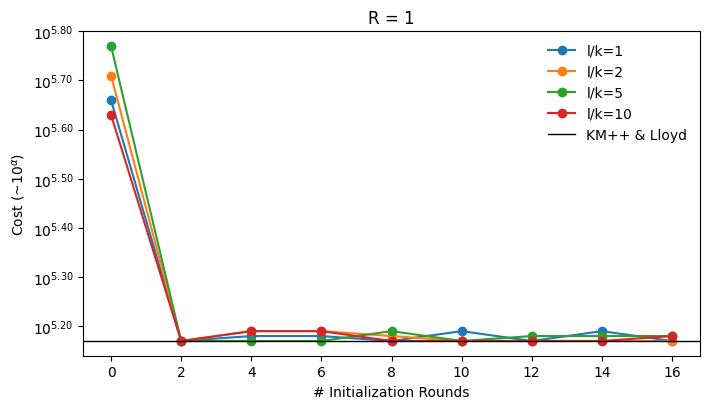

In [30]:
# ----- plot -----
fig, ax = plt.subplots(figsize=(7.2, 4.2))
for lk, phis in sorted(curves.items()):
    ax.plot(rounds, phis, marker='o', linewidth=1.5, label=f"l/k={lk}")

# if baseline:
ax.axhline(base, color='k', lw=1, label='KM++ & Lloyd')

ax.set_xlabel("# Initialization Rounds")
ax.set_ylabel("Cost (~$10^{\\alpha}$)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))

lo = min(min(v) for v in curves.values())
hi = max(max(v) for v in curves.values())

# ax.set_ylim(lo-0.01, hi)
ax.set_title(f"R = {R}")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

In [31]:
# ----- controls -----
R = 10
data_narray10, true_centroids10 = gauss_mixture(n, k, dim, R)
data_rdd10 = sc.parallelize([row for row in data_narray10])

In [32]:
# compute curves (KM|| seeds + Lloyd):
curves10 = run_curves(data_rdd10, k, rounds, lk_ratio, iterations)
# baseline (KM++ seeds + Lloyd):
Cpp10   = kMeansPlusPlus_init(data_narray10, k)
CppFin10 = naiveKMeans(data_rdd10, Cpp10, epochs=100_000)
base10   = exp10_cost(cost_function(data_rdd10, CppFin10), 2)

COMPLETED: 
##########|	l/k = 1  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 8	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 12	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 14	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 16	|##########
DONE!
COMPLETED: 
##########|	l/k = 2  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 8	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 12	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 14	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 16	|##########
DONE!
COMPLETED: 
##########|	l/k = 5  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 8	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 12	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 14	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 16	|##########
DONE!
COMPLETED: 
##########|	l/k = 10  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 8	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 12	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 14	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 16	|##########
DONE!


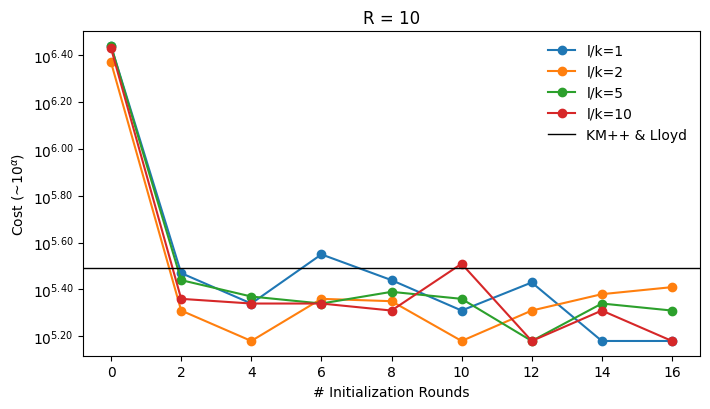

In [33]:
# ----- plot -----
fig, ax = plt.subplots(figsize=(7.2, 4.2))
for lk, phis in sorted(curves10.items()):
    ax.plot(rounds, phis, marker='o', linewidth=1.5, label=f"l/k={lk}")

# if baseline:
ax.axhline(base10, color='k', lw=1, label='KM++ & Lloyd')

ax.set_xlabel("# Initialization Rounds")
ax.set_ylabel("Cost (~$10^{\\alpha}$)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))

lo = min(min(v) for v in curves10.values())
hi = max(max(v) for v in curves10.values())

# ax.set_ylim(lo-0.01, hi)
ax.set_title(f"R = {R}")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

In [34]:
# ----- controls -----
R = 100
data_narray100, true_centroids100 = gauss_mixture(n, k, dim, R)
data_rdd100 = sc.parallelize([row for row in data_narray100])

In [35]:
# compute curves (KM|| seeds + Lloyd):
curves100 = run_curves(data_rdd100, k, rounds, lk_ratio, iterations)
# baseline (KM++ seeds + Lloyd):
Cpp100   = kMeansPlusPlus_init(data_narray100, k)
CppFin100 = naiveKMeans(data_rdd100, Cpp100, epochs=100_000)
base100   = exp10_cost(cost_function(data_rdd100, CppFin100), 2)

COMPLETED: 
##########|	l/k = 1  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 8	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 12	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 14	|##########
COMPLETED: 
##########|	l/k = 1  |  r = 16	|##########
DONE!
COMPLETED: 
##########|	l/k = 2  |  r = 0	|##########


COMPLETED: 
##########|	l/k = 2  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 8	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 12	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 14	|##########
COMPLETED: 
##########|	l/k = 2  |  r = 16	|##########
DONE!
COMPLETED: 
##########|	l/k = 5  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 8	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 5  |  r = 12	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 14	|##########


COMPLETED: 
##########|	l/k = 5  |  r = 16	|##########
DONE!
COMPLETED: 
##########|	l/k = 10  |  r = 0	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 2	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 4	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 6	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 8	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 10	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 12	|##########
COMPLETED: 
##########|	l/k = 10  |  r = 14	|##########


COMPLETED: 
##########|	l/k = 10  |  r = 16	|##########
DONE!


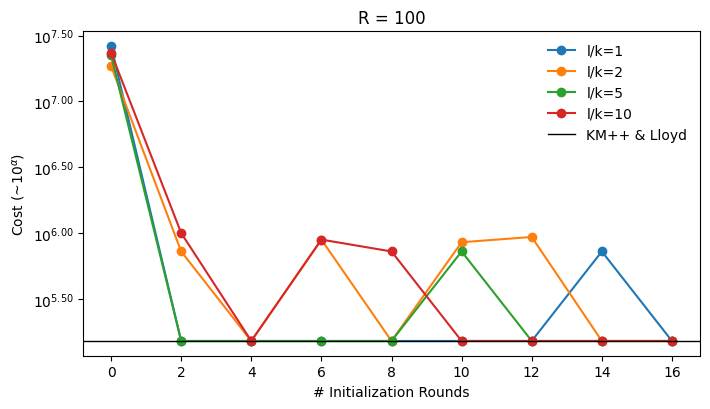

In [36]:
# ----- plot -----
fig, ax = plt.subplots(figsize=(7.2, 4.2))
for lk, phis in sorted(curves100.items()):
    ax.plot(rounds, phis, marker='o', linewidth=1.5, label=f"l/k={lk}")

# if baseline:
ax.axhline(base100, color='k', lw=1, label='KM++ & Lloyd')

ax.set_xlabel("# Initialization Rounds")
ax.set_ylabel("Cost (~$10^{\\alpha}$)")
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: rf"$10^{{{y:.2f}}}$"))

lo = min(min(v) for v in curves.values())
hi = max(max(v) for v in curves.values())

#ax.set_ylim(lo-0.01, hi)
ax.set_title(f"R = {R}")
ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.tight_layout()
plt.show()

## KMeans further Analysis

In [ ]:
def analysis(
        data_array: npt.ArrayLike, 
        data_rdd: RDD, 
        r: int=0, 
        k: int=50, 
        lk_ratio: float=0.5,
        iterations: int=5, 
        batch_fraction: float=0.1,
        init_algo: str="random",
        up_algo: str="naive",
        ) -> npt.DTypeLike:
    
    results = []
    start = time.time()
    ######## Init ########
    if init_algo=="random": 
        centroids_init  = data_array[np.random.choice(data_array.shape[0], size=k, replace=False)]
        init_time = time.time() - start
        seed_cost = cost_function(data_rdd, centroids_init)
    elif init_algo=="kmeans++": 
        centroids_init = kMeansPlusPlus_init(data_array, k)
        init_time = time.time() - start
        seed_cost = cost_function(data_rdd, centroids_init)
    else: 
        init_time = []
        seed_cost = []
        for lk in lk_ratio:
            centroids_init = kMeansParallel_init(data_rdd, k=k, l=lk*k, r=r)
            init_time.append(time.time() - start)
            start = time.time()
            seed_cost.append(cost_function(data_rdd, centroids_init))

    start = time.time()
    ######## Algo ########
    if up_algo=="naive": final_centroids = naiveKMeans(data_rdd, centroids_init, iterations)
    else: final_centroids = miniBatchKMeans(data_rdd, centroids_init, iterations, batch_fraction)
    final_time = time.time() - start
    final_cost = cost_function(data_rdd, final_centroids)
    
    results.append({
        "method": init_algo,
        "algo": up_algo,
        "initialization_time (s)": f"{init_time:.3f}",
        "algo time (s)":f"{final_time:.3f}",
        "seed": f"{seed_cost/1e4:.3f}",
        "final": f"{final_cost/1e4:.3f}"
    })
    df = pd.DataFrame(results)
    return df

Paper analysis on Gaussian mixture

In [ ]:
R = [1, 10, 100]
res = []

n = 10_000
k = 50
dim = 15
r = 5
iterations = 100_000
batch_fraction = 0.3

for RR in R:
    data_array, true_centroids = gauss_mixture(n, k, dim, R=RR)
    data_rdd = sc.parallelize([row for row in data_array]).persist()
    for init_algo in ["random", "kmeans++", "kmeans||"]:
        df = analysis(
                data_array, 
                data_rdd, 
                r=r, 
                k=50, 
                lk_ratio=[0.5, 2],
                iterations=iterations, 
                batch_fraction=0.1,
                init_algo="random",
                up_algo="naive",
            )
        print(
            f"R={RR}\t", 
            f"algo={algo}", "\n","------------------------------", "\n"
        )

        res.append(df)
        data_rdd.unpersist()

# Lloyd Parallel vs. nPartitions

# Lloyd vs. Mini-Batch